## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### Importing the required libraries

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

### Supporting functions

In [2]:
def print_two_images(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
def read_image(file_path):
    return mpimg.imread(file_path)

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx, ny = 6, 9
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:ny,0:nx].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (ny,nx),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    else:
        print("This image could not be used for callibration: " + fname)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Amount of images used for calibration: " + str(len(images)))
print("Amount of sucessfull calibrations: " + str(len(objpoints)))

This image could not be used for callibration: ../camera_cal/calibration1.jpg
This image could not be used for callibration: ../camera_cal/calibration4.jpg
This image could not be used for callibration: ../camera_cal/calibration5.jpg
Amount of images used for calibration: 20
Amount of sucessfull calibrations: 17


 ## Applying a distortion correction to raw images

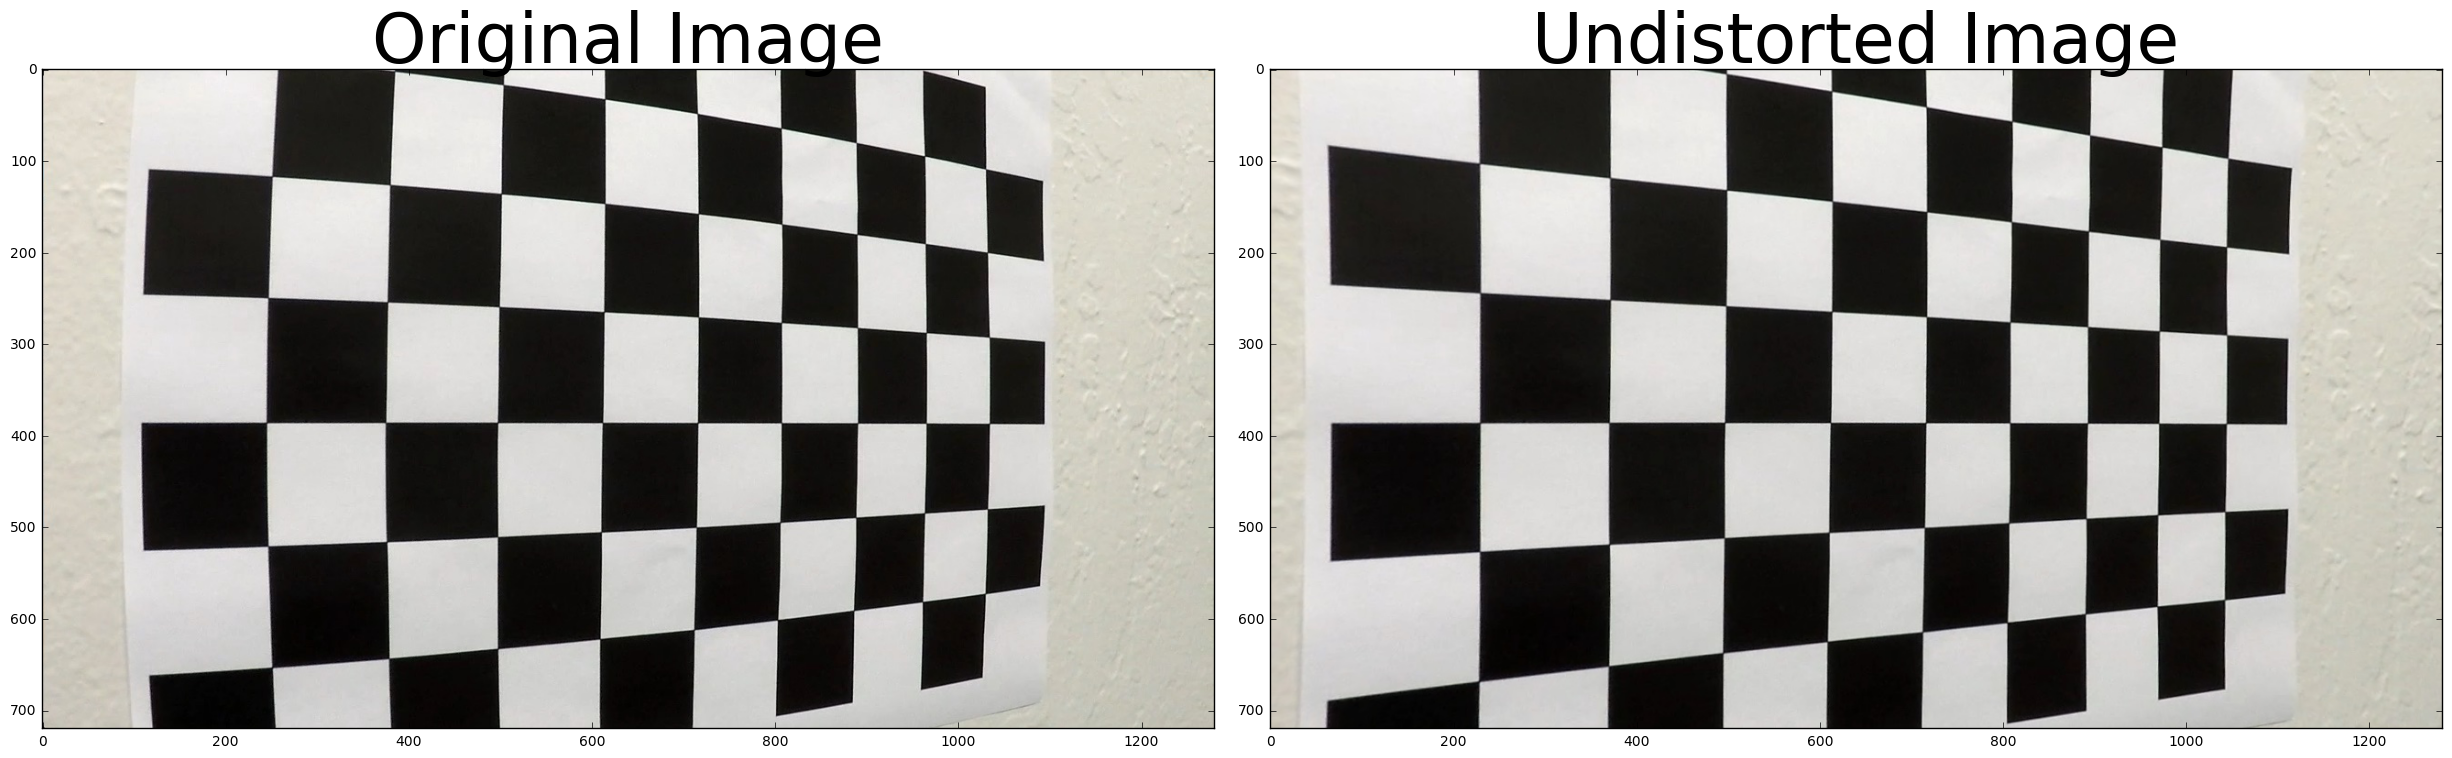

In [4]:
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img1 = read_image("../camera_cal/calibration5.jpg")
img2 = undistort_image(img1, mtx, dist)

print_two_images(img1, img2, "Original Image", "Undistorted Image")

### Applying thresholding to an image

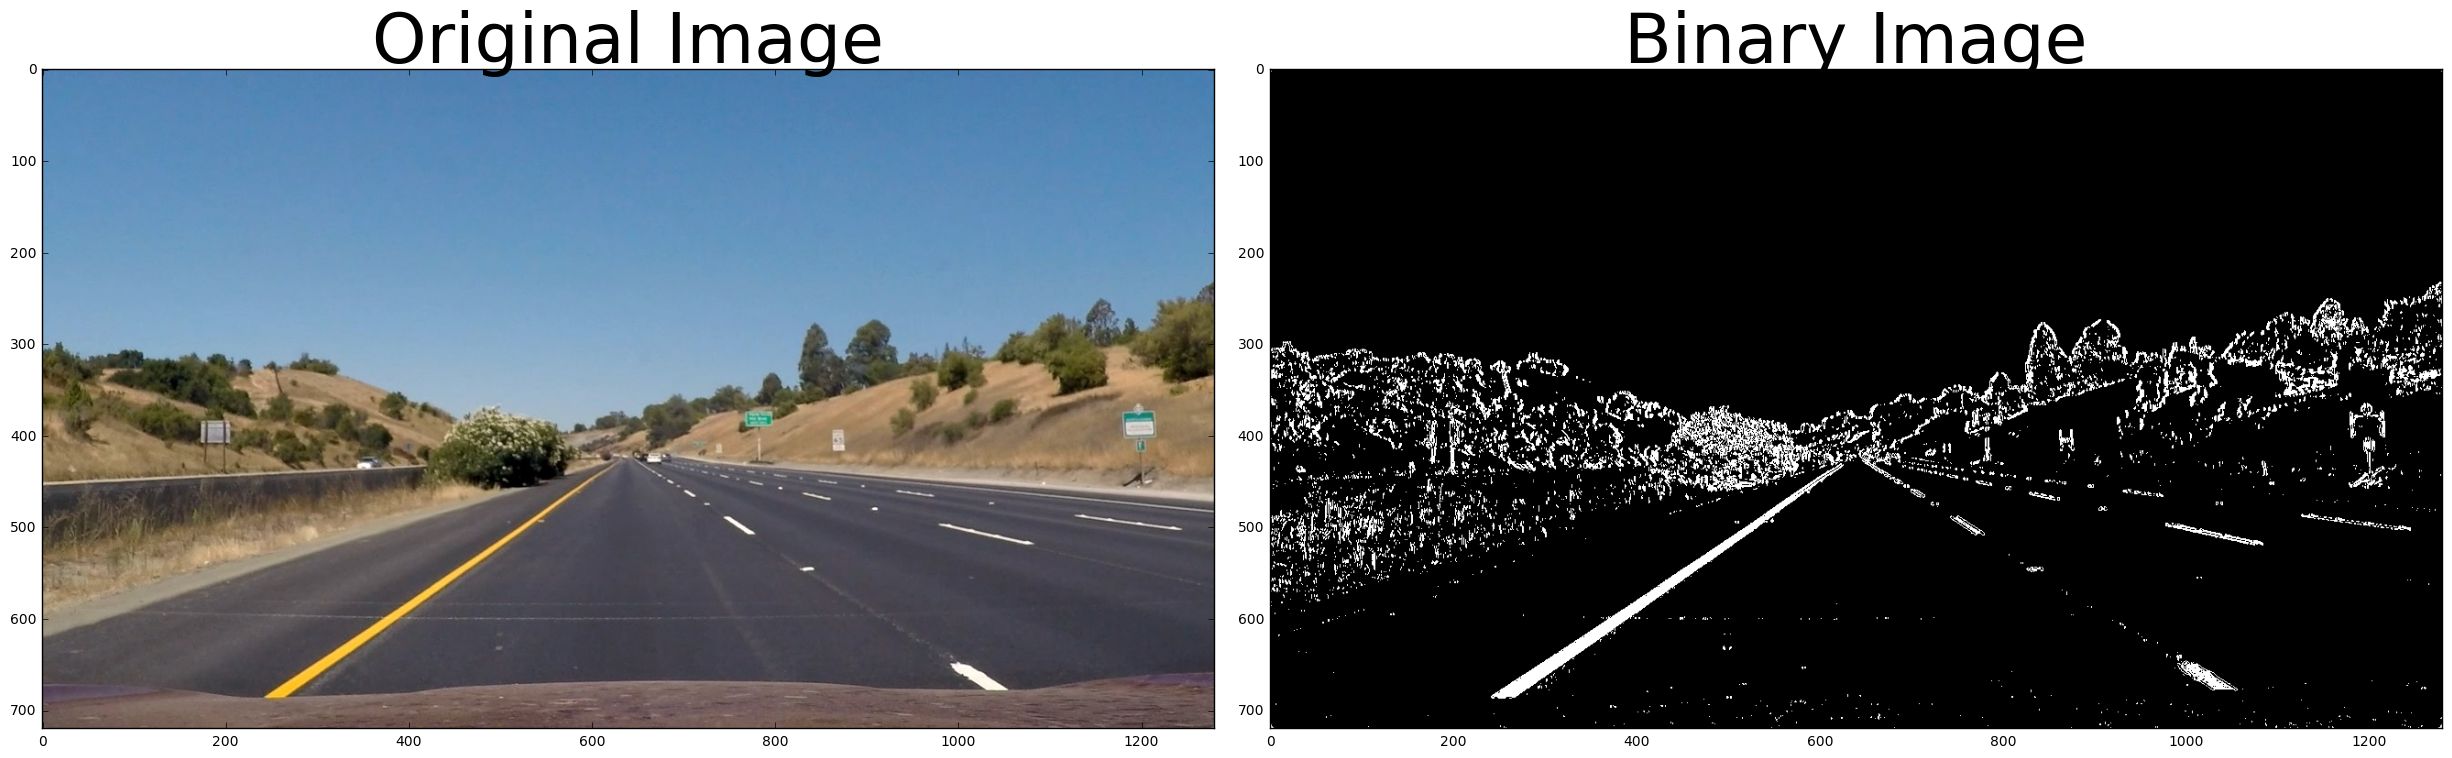

In [5]:
def apply_threshold(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

filename = "../test_images/straight_lines1.jpg"
img1 = read_image(filename)
img2= apply_threshold(img1)

print_two_images(img1, img2, "Original Image", "Binary Image")

### Bird view

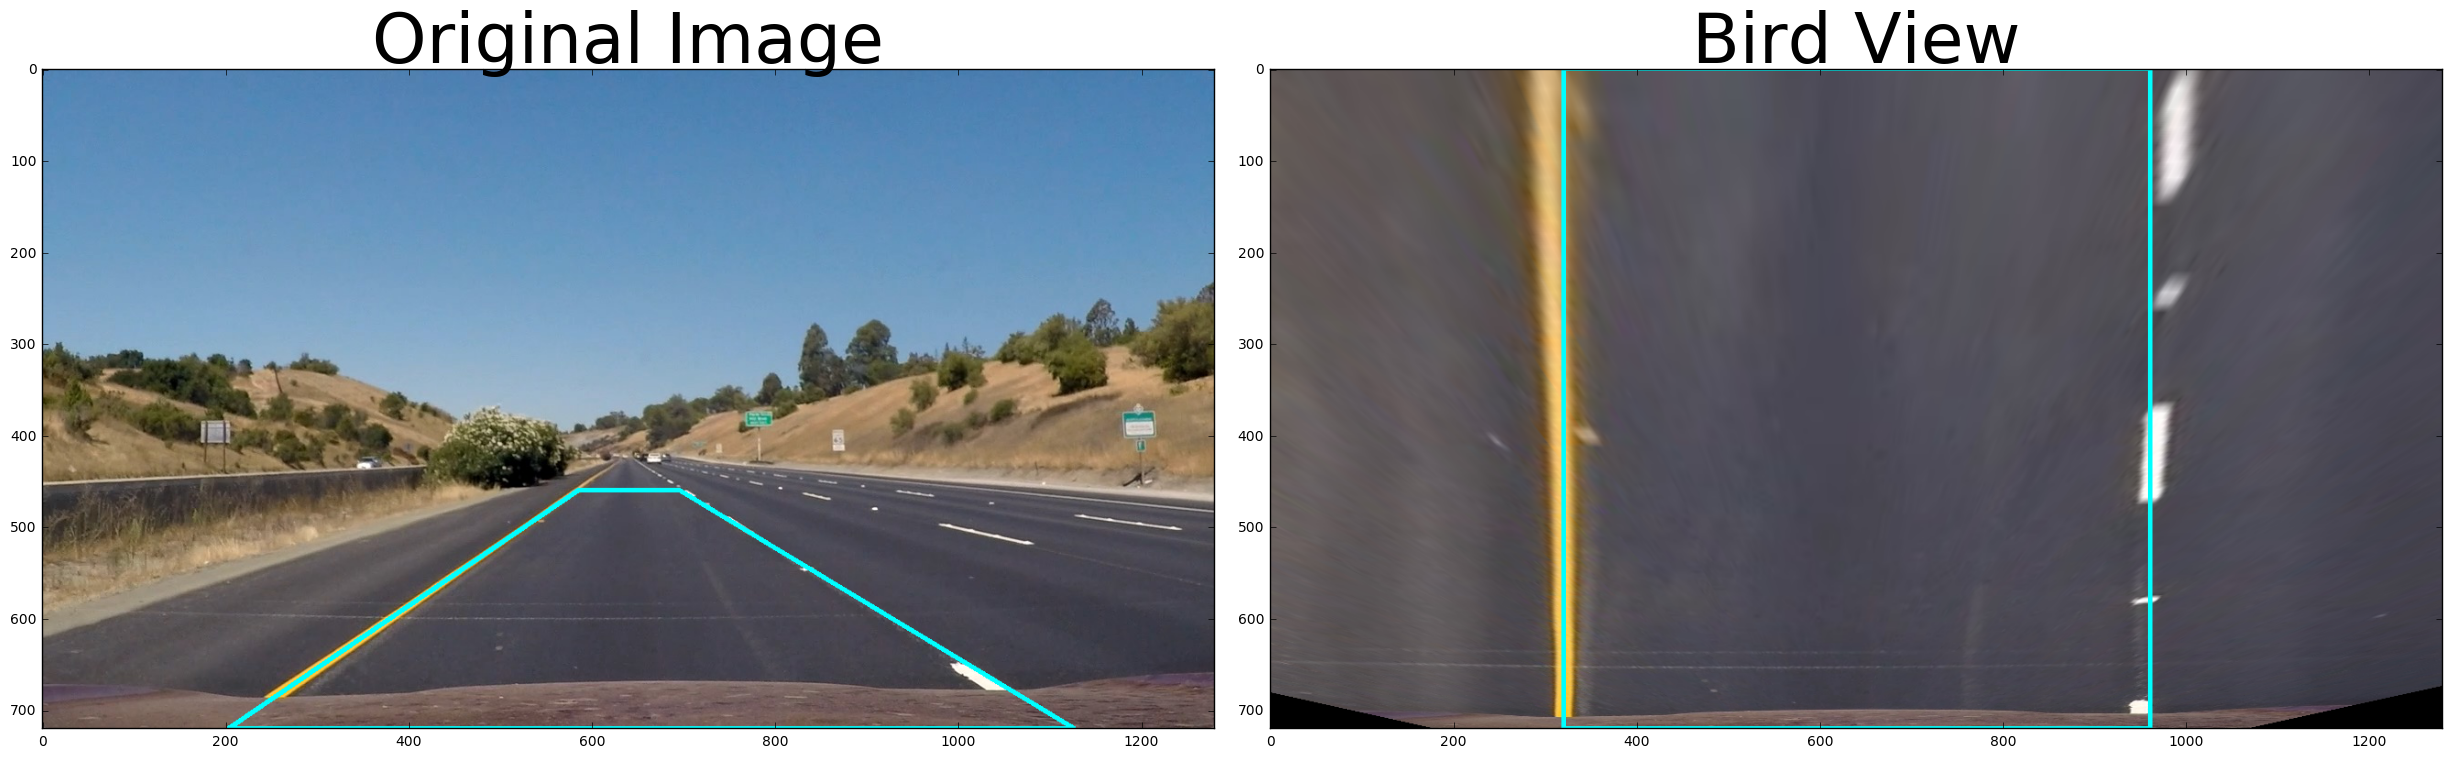

In [6]:
def apply_transform(image, draw_poly=False):
    img_size = [image.shape[1], image.shape[0]]

    src = np.float32(
         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
         [((img_size[0] / 6) - 10), img_size[1]],
         [(img_size[0] * 5 / 6) + 60, img_size[1]],
         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
         [[(img_size[0] / 4), 0],
         [(img_size[0] / 4), img_size[1]],
         [(img_size[0] * 3 / 4), img_size[1]],
         [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    
    if draw_poly:
        src_poly = np.array(((src[0][0], src[0][1]), (src[1][0], src[1][1]), (src[2][0], src[2][1]), (src[3][0], src[3][1])), np.int32)
        cv2.polylines(image, [src_poly], True, (0,255,255),3)
    
        dst_poly = np.array(((dst[0][0], dst[0][1]), (dst[1][0], dst[1][1]), (dst[2][0], dst[2][1]), (dst[3][0], dst[3][1])), np.int32)
        cv2.polylines(warped, [dst_poly], True, (0,255,255),3)
    
    return warped
    
filename = "../test_images/straight_lines1.jpg"
img1 = read_image(filename)
img2 = apply_transform(img1, draw_poly=True)

print_two_images(img1, img2, "Original Image", "Bird View")

### Detecting the lane lines

/Users/vspreys/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


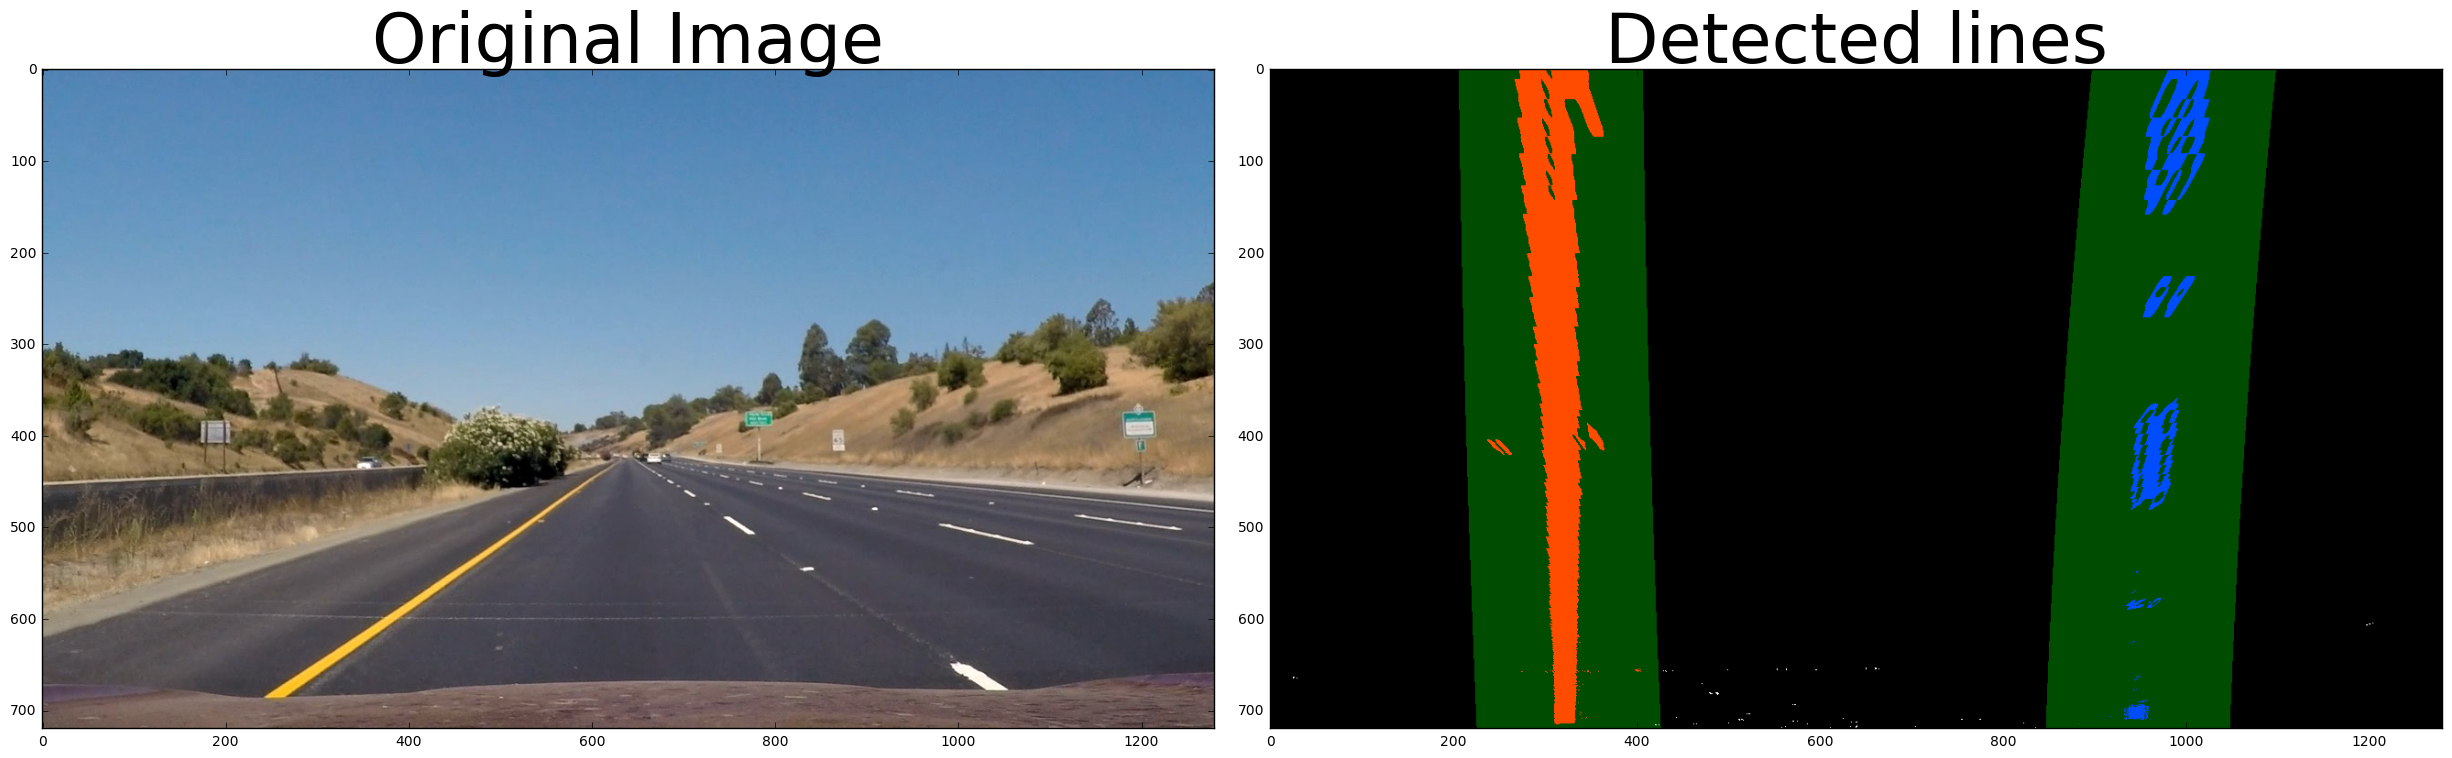

In [7]:
def detect_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, leftx, rightx, ploty
    

filename = "../test_images/straight_lines1.jpg"
img1 = read_image(filename)

undistorted = undistort_image(img1, mtx, dist)
binarized = apply_threshold(undistorted)
bird_view = apply_transform(binarized)
detected_lines, leftx, rightx, ploty = detect_lines(bird_view)

print_two_images(img1, detected_lines, "Original Image", "Detected lines")

In [8]:
# # # Generate some fake data to represent lane-line pixels
# #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
# # quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# # # For each y position generate random x position within +/-50 pix
# # # of the line base position in each case (x=200 for left, and x=900 for right)
# # # leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
# # #                               for y in ploty])
# # # rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
# # #                                 for y in ploty])

# #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
# #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# # Fit a second order polynomial to pixel positions in each fake lane line
# left_fit = np.polyfit(ploty, leftx, 2)
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fit = np.polyfit(ploty, rightx, 2)
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# # Plot up the fake data
# mark_size = 3
# plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
# plt.plot(left_fitx, ploty, color='green', linewidth=3)
# plt.plot(right_fitx, ploty, color='green', linewidth=3)
# plt.gca().invert_yaxis() # to visualize as we do the images

In [9]:
def project_line(warped, left_fitx, right_fitx):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

filename = "../test_images/straight_lines1.jpg"
img1 = read_image(filename)

undistorted = undistort_image(img1, mtx, dist)
binarized = apply_threshold(undistorted)
bird_view = apply_transform(binarized)
detected_lines, leftx, rightx, ploty = detect_lines(bird_view)

with_lines = project_line(bird_view, leftx, rightx)

/Users/vspreys/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: all the input array dimensions except for the concatenation axis must match exactly